# Example 1: Overview of the _Fermi_ Data

This example provides an overview of the _Fermi_-LAT gamma-ray data we have included with the code, which provide the testing ground for the examples in later notebooks.

**We emphasize that NPTFit is applicable much more generally. The code package can be implemented in any scenario in which the data is measured in discrete counts.** We use the example of _Fermi_ data here, as it represented some of the earliest applications of this code and also it is fully publicly available, see 
http://fermi.gsfc.nasa.gov/ssc/data/access/

The specifics of the dataset we use are given below.

| Parameter | Value |
| ------------- | ------------- |
| Energy Range | 2-20 GeV |
| Time Period | Aug 4, 2008 to July 7, 2016 (413 weeks) |
| Event Class | UltracleanVeto (1024) - highest cosmic ray rejection |
| Event Type | PSF3 (32) - top quartile graded by angular reconstruction |
| Quality Cuts | `DATA_QUAL==1 && LAT_CONFIG==1` |
| Max Zenith Angle | 90 degrees |

In [1]:
# Import relevant modules

%matplotlib inline
%load_ext autoreload
%autoreload 2

import os

import numpy as np
import healpy as hp

## Downloading the data

The _Fermi_ data used here can be downloaded from https://dspace.mit.edu/handle/1721.1/105492 along with a `README` detailing the data. The following commands automatically download and set up the data on a UNIX system:

In [2]:
# Assumes wget is available! Otherwise, use curl or download manually 
# from https://dspace.mit.edu/handle/1721.1/105492
os.system("wget https://dspace.mit.edu/bitstream/handle/1721.1/105492/fermi_data.tar.gz");
os.system("tar -xvf fermi_data.tar.gz");
os.system("rm -r fermi_data.tar.gz*");

## The Data - Map of Gamma-ray Counts

The data we have provided is in a single energy bin, so only spatial information of the photons remains. We bin this into an `nside=128` healpix map. This map has units of [photon counts/pixel]. The data is shown below on two scales, the second making it clear there are pixels with large numbers of counts - there are very bright gamma-ray sources in the data.

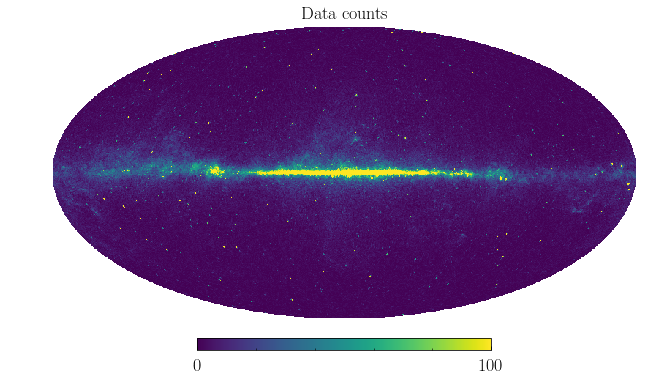

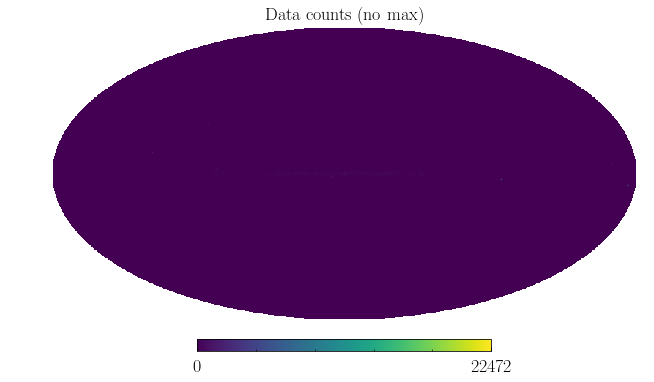

In [3]:
counts = np.load('fermi_data/fermidata_counts.npy')

hp.mollview(counts,title='Data counts',max=100)

hp.mollview(counts,title='Data counts (no max)')

To see the detailed structure in the map, we also mock up a logarithmic version of the data.

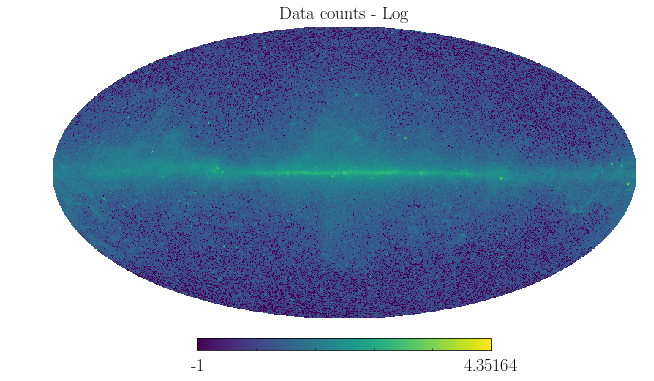

In [4]:
nonzero = np.where(counts != 0)[0]
zero = np.where(counts == 0)[0]
counts_log = np.zeros(len(counts))
counts_log[nonzero] = np.log10(counts[nonzero])
counts_log[zero] = -1
hp.mollview(counts_log,title='Data counts - Log')

## Exposure Map - Map of where _Fermi_-LAT looks

_Fermi_-LAT is a space based telescope that takes data from the entire sky. Nevertheless it does not look at every part of the sky equally, and the exposure map keeps track of this. 

The natural units for diffuse astrophysical sources is intensity [counts/cm$^2$/s/sr], whereas for point sources we use flux [counts/cm$^2$/s]. Neither of these knows _Fermi_ was pointing. But _Fermi_ measures counts or counts/pixel, and this is also the space in which we perform our statistical analysis. The mapping from [counts/cm$^2$/s(/sr)] to [counts(/pixel)] is performed by the exposure map, which has units of [cm$^2$ s].

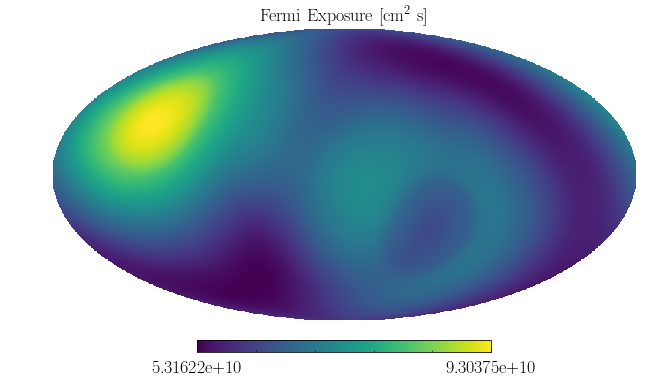

In [5]:
exposure = np.load('fermi_data/fermidata_exposure.npy')

hp.mollview(exposure,title='Fermi Exposure [cm$^2$ s]')

When performing an NPTF, technically the non-Poissonian templates should be separately exposure corrected in every pixel. Doing this exactly is extremely computationally demanding, and so instead we approximate this by breaking the exposure map up into regions of approximately similar exposure values.

For the Fermi instrument a small number of exposure values (set by `nexp` at the point of configuring a scan) is often sufficient, as the exposure is quite uniform over the sky. For datasets with less uniform exposure, however, larger values of `nexp` are recommended. We show a run performed with `nexp != 1` in Example 4 and 10.

Below we show how the sky is divided into different exposure regions - try changing `nexp`. 

**NB:** In the actual analysis the exposure region division is done within the specified ROI, not the entire sky

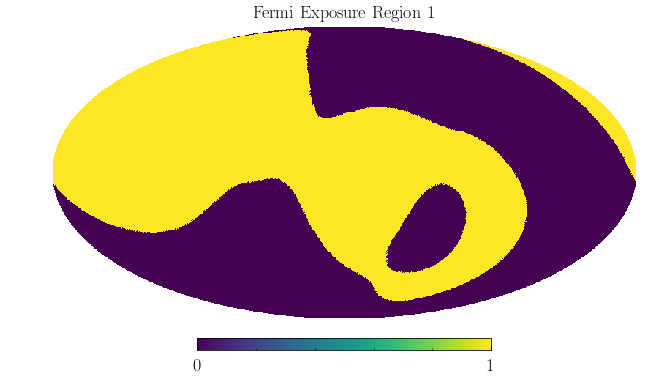

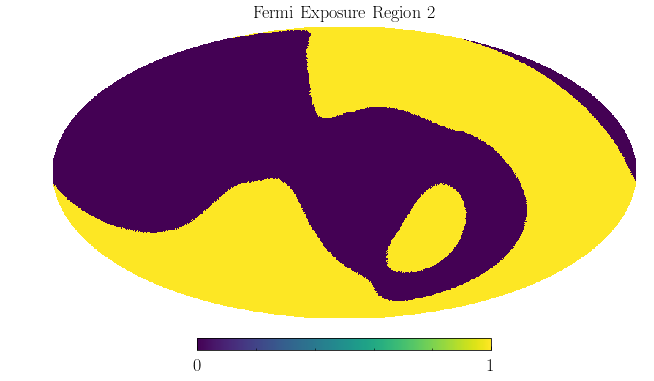

In [6]:
# Number of exposure regions - change this to see what the regions look like when dividing the full sky
nexp = 2

# Divide the exposure map into a series of masks
exp_array = np.array([[i, exposure[i]] for i in range(len(exposure))])
array_sorted = exp_array[np.argsort(exp_array[:, 1])]
array_split = np.array_split(array_sorted, nexp)
expreg_array = [[int(array_split[i][j][0]) for j in range(len(array_split[i]))] for i in range(len(array_split))]
temp_expreg_mask = []
for i in range(nexp):
    temp_mask = np.logical_not(np.zeros(len(exposure)))
    for j in range(len(expreg_array[i])):
        temp_mask[expreg_array[i][j]] = False
    temp_expreg_mask.append(temp_mask)
expreg_mask = temp_expreg_mask

for ne in range(nexp):
    hp.mollview(expreg_mask[ne],title='Fermi Exposure Region '+str(ne+1),min=0,max=1)

## Point Source Catalog Mask

We also include a mask of all point sources in the 3FGL, as well as large extended objects such as the Large Magellanic Cloud. All point sources are masked at 95% containment as appropriate for this `nside`. The map below is a mask, so just a boolean array

Note that with the NPTF it is not always desirable to mask point sources - we can often simply use a non-Poissonian template to model them.

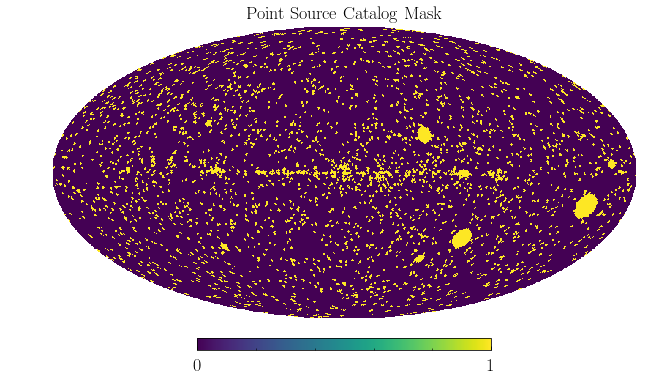

In [7]:
pscmask = np.load('fermi_data/fermidata_pscmask.npy')

hp.mollview(pscmask, title='Point Source Catalog Mask')

## Templates - Spatial Models for the Fermi Data

Next we show the different spatial templates that we will use to model the above Fermi data. These also represent examples for the types of models we can use as a basis for either Poissonian or non-Poissonian templates.

**Note that templates given to the NPTF must be exposure corrected. That is they should be models of counts, not flux. Furthermore they should also be smoothed to account for the PSF if necessary.**

In addition to exposure correcting the maps, for each template below we have also adjusted it so that it has mean 1 within an ROI defined by $|b|>2^{\circ}$ and $r<30^{\circ}$.

### Diffuse Emission

Firstly we show a model for the diffuse emission, which arises mainly from three sources: 1. protons hitting the gas, giving rise to pions which then decay to photons ($pp \to \pi^0 \to \gamma \gamma$); 2. inverse compton scattering from electrons upscattering starlight or the CMB; and 3. bremsstrahlung off of ambient gas.

This model accounts for the majority of the _Fermi_ data. We use the _Fermi_ p6v11 model for the purpose (as it does not also include a template for the _Fermi_ bubbles which we model separately).

Below we show a log and linear version of the map, as we did for the data.

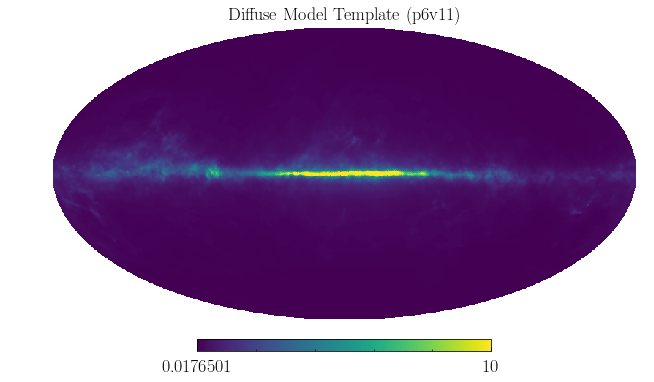

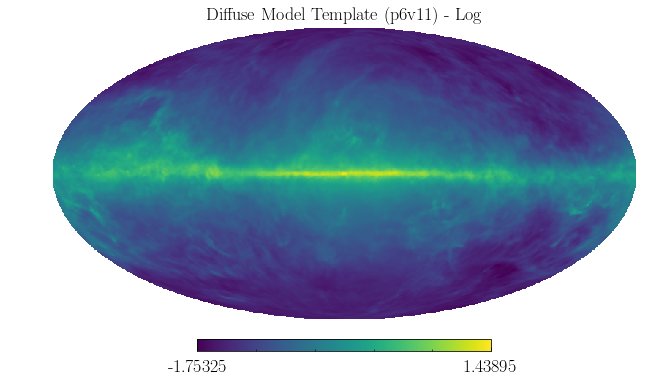

In [8]:
dif = np.load('fermi_data/template_dif.npy')

hp.mollview(dif,title='Diffuse Model Template (p6v11)',max=10)

hp.mollview(np.log10(dif),title='Diffuse Model Template (p6v11) - Log')

### Isotropic Emission

There is also an approximately isotropic contribution to the data from extragalactic emission and also cosmic ray contamination. Note that this map makes the fact the template has been exposure corrected manifest.

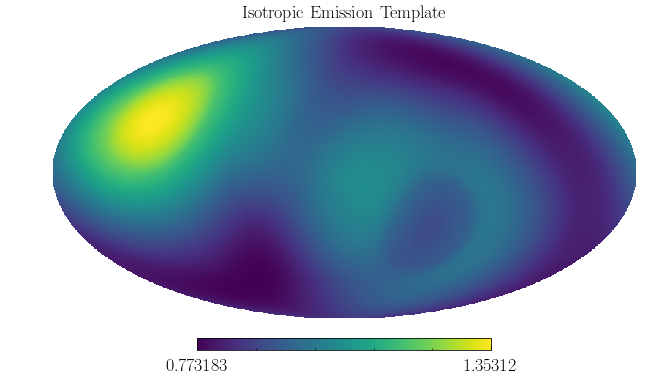

In [9]:
iso = np.load('fermi_data/template_iso.npy')

hp.mollview(iso,title='Isotropic Emission Template')

### _Fermi_ Bubbles

We also provide a separate model for emission from the _Fermi_ bubbles. Emission from the bubbles is taken to be uniform in intensity, which becomes non-uniform in counts after exposure correction.

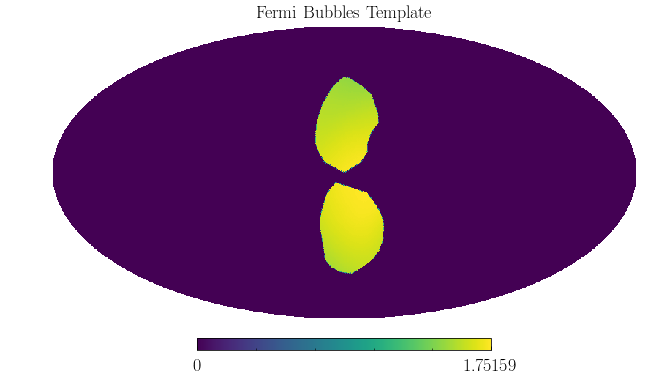

In [10]:
bub = np.load('fermi_data/template_bub.npy')

hp.mollview(bub,title='Fermi Bubbles Template')

### Point Source Catalog Model

As seen in the initial data, the gamma-ray sky includes some extremely bright point sources. As such even if a mask is used to largely cover these, it is still often a good idea to model the point sources as well. Below we show the template for these point sources.

A linear plot of this map shows that these point sources are quite localised on the sky, but in the log plot below we can clearly see their spread due to the Fermi PSF.

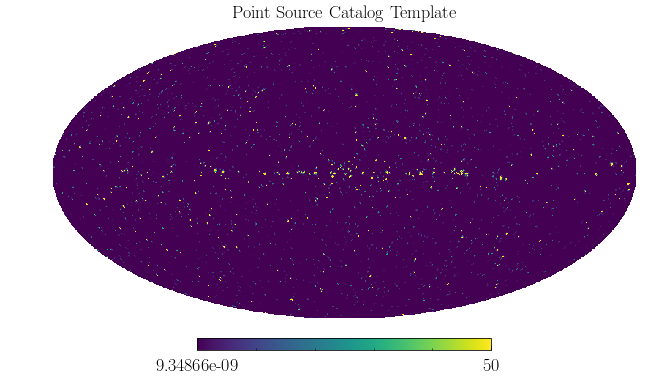

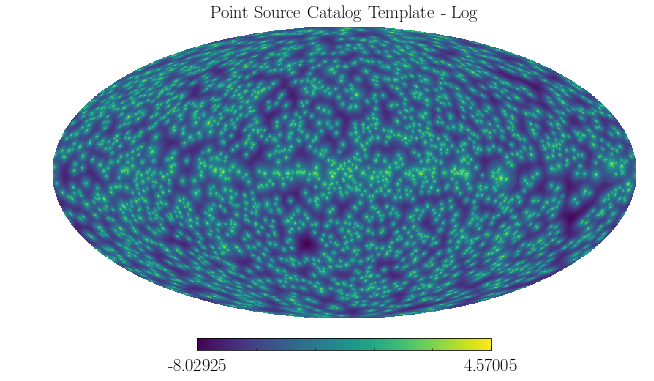

In [11]:
psc = np.load('fermi_data/template_psc.npy')

hp.mollview(psc,title='Point Source Catalog Template',max=50)

hp.mollview(np.log10(psc),title='Point Source Catalog Template - Log')

### Model for the Galactic Center Excess

Finally we include a model to describe the Galactic Center Excess (GCE). Regardless of the origin of this excess, it has been shown to be spatially distributed as approximately a squared generalized Navarro–Frenk–White (NFW) profile integrated along the line of sight. The generalized NFW for the Milky Way has the form: 

$$\rho(r) = \rho_0 \frac{(r/r_s)^{-\gamma}}{(1+r/r_s)^{3-\gamma}}\,,$$

where $r$ is the distance from the Galactic center. We take $r_s = 8.5$ kpc, $\gamma = 1.0$, and choose $\rho_0$ such that $\rho(r_s) = 0.4$ GeV/cm$^3$. The flux GCE template is then formed as:

$$J(\psi) = \int_{\rm los} \rho^2(r) ds\,,$$

where $s$ parameterizes the line of sight distance, which is integrated over, and $\psi$ is the angle away from the Galactic center.

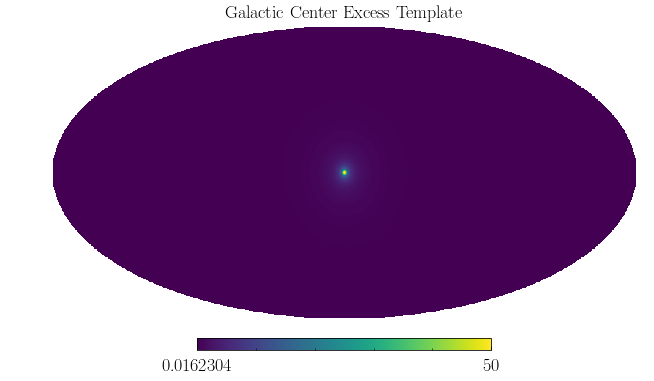

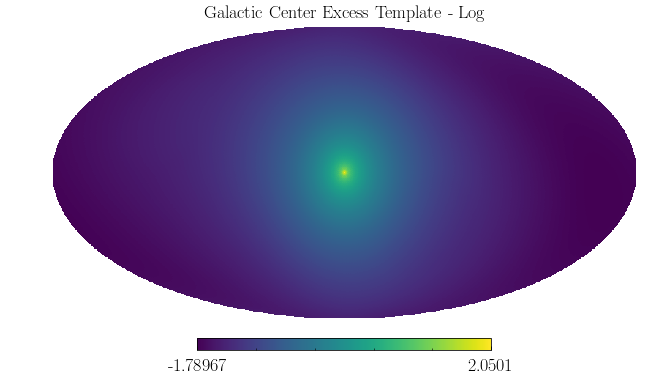

In [12]:
gce = np.load('fermi_data/template_gce.npy')

hp.mollview(gce,title='Galactic Center Excess Template',max=50)

hp.mollview(np.log10(gce),title='Galactic Center Excess Template - Log')

### Model for Disk Correlated Point Sources

When studying the point source origin of the GCE - done in Example 8 - we will also include a model for point sources correlated with the disk of the Milky Way. For this purpose we use the following thin disk double exponential model for the point source population:

$$n(z,R) \propto \exp \left( - R / 5~\textrm{kpc} \right) \exp \left( - |z| /0.3~\textrm{kpc} \right)\,,$$

where $R$ and $z$ are cylindrical polar coordinates measured from the Galactic Center.

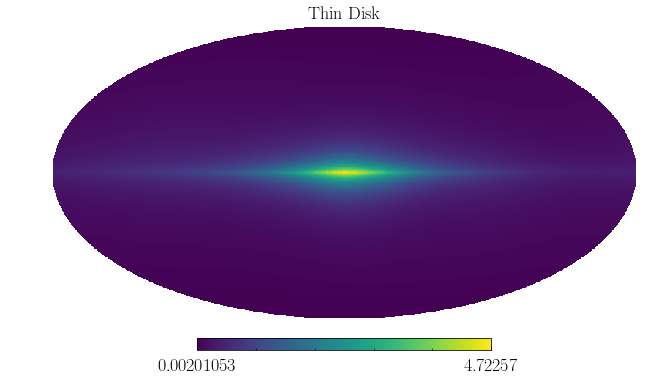

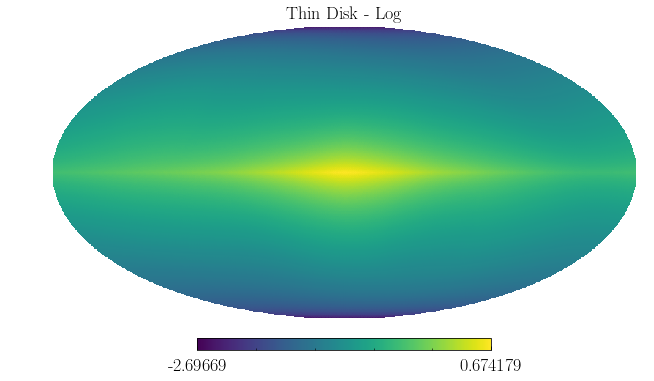

In [13]:
disk = np.load('fermi_data/template_dsk.npy')

hp.mollview(disk,title='Thin Disk')

hp.mollview(np.log10(disk),title='Thin Disk - Log')